In [1]:
# Import des librairies.
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import scipy.stats as ss  
import pingouin as pg
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import randint, uniform
import random
from functions import * 
import locale
import os
from tabulate import tabulate

# Options d'affichage.

# Configuration du style de visualisation des graphiques avec un style personnel (pitayasmoothie-dark).
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")



# 1. Importation, exploration et nettoyage des donnees

In [3]:
import pandas as pd

# Importation des fichiers.
synth = pd.read_csv("donnees.csv")
df_light = pd.read_csv("donneeslight.csv")

# Création d'une copie dans un DataFrame.
df_synth = synth.copy()

# Transtypage de "Categorie", "Saison" et "CategorieAgeProduit" en type "category" pour df_synth.
df_synth[['Categorie', 'Saison', 'CategorieAgeProduit']] = df_synth[['Categorie', 'Saison', 'CategorieAgeProduit']].astype('category')
# Transtypage de "Categorie", "Saison" et "CategorieAgeProduit" en type "category" pour df_light.
df_light[['Categorie', 'Saison', 'CategorieAgeProduit']] = df_light[['Categorie', 'Saison', 'CategorieAgeProduit']].astype('category')

# Mappage des valeurs de la colonne "Elasticite" et transtypage en "category" pour df_synth.
elasticite_cat_mapping = {
    1.5: 'Elastique',
    0.5: 'Inelastique',
    1.0: 'Neutre'
}
df_synth['elasticite_cat'] = df_synth['Elasticite'].map(elasticite_cat_mapping).astype('category')
df_light['elasticite_cat'] = df_light['Elasticite'].map(elasticite_cat_mapping).astype('category')

# Transtypage de "DateLancement" en type "datetime" pour df_synth et df_light.
df_synth['DateLancement'] = pd.to_datetime(df_synth['DateLancement'])
df_light['DateLancement'] = pd.to_datetime(df_light['DateLancement'])

# Conversion de la colonne 'Date' en type datetime pour df_synth et df_light.
df_synth['Date'] = pd.to_datetime(df_synth['Date'])
df_light['Date'] = pd.to_datetime(df_light['Date'])

# Date de début pour les trois derniers mois.
derniere = df_synth['Date'].max()
offset_trim = derniere - pd.DateOffset(months=3)

# Séparation des données pour le train et la validation.
df_validation = df_synth[df_synth['Date'] >= offset_trim].copy()  
df = df_synth[df_synth['Date'] < offset_trim].copy()  

# Séparation des trois derniers mois pour le jeu de validation léger.
derniere_light = df_light['Date'].max()
offset_trim_light = derniere_light - pd.DateOffset(months=3)
df_light_validation = df_light[df_light['Date'] >= offset_trim_light].copy()
df_light = df_light[df_light['Date'] < offset_trim_light].copy()  


In [4]:
df_validation.to_csv("df_validation_viz.csv", index=False)

In [11]:
df_synth

,Categorie,SKU,Date,Prix,PrixInitial,DateLancement,TempsDepuisLancement,CategorieAgeProduit,NombreDeJoursEnRayon,Saison,TauxInflation,Elasticite,ChocDemande,ChangementPrix,FacteurRarete,FacteurSaison,MarcheAleatoire,ChocDemandeCumulatif,AgeProduitEnJours,elasticite_cat
0,Electronique,Electronique_SKU_0,2019-11-29 05:44:17.007894,959.771248,932.445009,2019-11-29 05:44:17.007894,0,Nouveau,26.133994,4,0.0000,1.5,-0.001487,27.326239,1.045108,1.000000,959.771248,-0.049004,0,Elastique
1,Electronique,Electronique_SKU_0,2019-12-26 05:44:17.007894,935.002558,932.445009,2019-11-29 05:44:17.007894,27,Nouveau,105.205494,1,0.0000,1.5,0.016623,2.557549,1.007569,1.050000,935.002558,0.158256,27,Elastique
2,Electronique,Electronique_SKU_0,2020-01-22 05:44:17.007894,1034.500719,932.445009,2019-11-29 05:44:17.007894,54,Nouveau,40.329843,1,0.0149,1.5,-0.030402,102.055710,0.918437,1.086603,1034.500719,-0.034539,54,Elastique
3,Electronique,Electronique_SKU_0,2020-02-18 05:44:17.007894,1080.665923,932.445009,2019-11-29 05:44:17.007894,81,Nouveau,12.546361,1,0.0143,1.5,-0.064666,148.220913,1.032175,1.100000,1080.665923,0.129407,81,Elastique
4,Electronique,Electronique_SKU_0,2020-03-17 05:44:17.007894,1038.920019,932.445009,2019-11-29 05:44:17.007894,109,Nouveau,19.692410,2,0.0067,1.5,-0.091695,106.475010,0.972270,1.086603,1038.920019,0.053649,109,Elastique
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178237,Livres,Livres_SKU_1999,2021-12-01 14:20:27.316648,21.945689,18.675390,2019-10-30 14:20:27.316648,763,Ancien,229.416255,1,0.0160,1.0,-0.041881,3.270300,1.034269,1.086603,21.945689,0.247637,763,Neutre
178238,Livres,Livres_SKU_1999,2021-12-28 14:20:27.316648,20.206590,18.675390,2019-10-30 14:20:27.316648,790,Ancien,339.163842,1,0.0160,1.0,0.070477,1.531200,0.946595,1.050000,20.206590,-0.057776,790,Neutre
178239,Livres,Livres_SKU_1999,2022-01-25 14:20:27.316648,21.375820,18.675390,2019-10-30 14:20:27.316648,818,Ancien,302.965076,1,0.0290,1.0,0.095710,2.700431,1.022309,1.000000,21.375820,0.048222,818,Neutre
178240,Livres,Livres_SKU_1999,2022-02-21 14:20:27.316648,19.807978,18.675390,2019-10-30 14:20:27.316648,845,Ancien,181.853769,1,0.0360,1.0,-0.032469,1.132588,0.974541,0.950000,19.807978,0.496226,845,Neutre


### Explication des Variables

1. **Categorie** :
   - La catégorie du produit, par exemple, "Electronique", "Vetements", ou "Livres".

2. **SKU** :
   - L'identifiant unique du produit.

3. **Mois** :
   - Le mois de l'observation.

4. **Annee** :
   - L'année de l'observation.

5. **Date** :
   - La date précise de l'observation.

6. **Prix** :
   - Le prix du produit à la date de l'observation.

7. **PrixInitial** :
   - Le prix initial du produit lors de son lancement.

8. **DateLancement** :
   - La date de lancement du produit.

9. **Saison** :
   - La saison approximative de l'observation, catégorisée comme suit :
     - 1 = Hiver
     - 2 = Printemps
     - 3 = Été
     - 4 = Automne

10. **TauxInflation** :
    - Le taux d'inflation applicable à la date de l'observation, obtenu à partir du dictionnaire des taux d'inflation mensuels.

11. **Elasticite** :
    - L'élasticité prix du produit, indiquant la sensibilité de la demande aux changements de prix.

12. **ChocDemande** :
    - Le changement aléatoire de la demande pour le produit ce mois.
    - **Calcul** : Généré aléatoirement entre -0.1 et 0.1 : `np.random.uniform(-0.1, 0.1)`.

13. **LogPrix** :
    - Le logarithme naturel du prix du produit.
    - **Calcul** : `np.log(Prix)`.

14. **ChangementPrix** :
    - La différence entre le prix actuel et le prix initial.
    - **Calcul** : `Prix - PrixInitial`.

15. **FacteurRarete** :
    - Un facteur de rareté appliqué au prix, reflétant l'effet de la rareté sur le prix.
    - **Calcul** : Généré aléatoirement entre 0.9 et 1.1 pour l'électronique, entre 0.95 et 1.05 pour les livres, et entre 0.9 et 1.1 pour les vêtements.

16. **FacteurSaison** :
    - Un facteur de saisonnalité appliqué au prix, reflétant l'effet de la saison sur le prix.
    - **Calcul** : 1 + un terme saisonnier basé sur une fonction sinus :
      - Électronique : `1 + 0.1 * np.sin(2 * np.pi * t)`
      - Livres : `1 + 0.05 * np.sin(2 * np.pi * t)`
      - Vêtements : `1 + 0.15 * np.sin(2 * np.pi * t)`

17. **MarcheAleatoire** :
    - Le prix après application de la marche aléatoire (simulation de fluctuations aléatoires).
    - **Calcul** : Moyenne des prix après application des chocs aléatoires dans la simulation :
      - `np.mean([prix * np.exp(np.random.normal(0, 0.05)) for _ in range(nombre_simulations)])`

18. **ChocDemandeCumulatif** :
    - Le choc de demande cumulé jusqu'à ce point, représentant l'effet agrégé des changements de demande.
    - **Calcul** : Somme des chocs de demande jusqu'à l'observation courante :
      - `sum([np.random.uniform(-0.1, 0.1) for _ in range(i + 1)])`

19. **AgeProduitEnJours** :
    - L'âge du produit en jours à la date de l'observation.
    - **Calcul** : `AgeProduitEnJours = (Date - DateLancement).days`

20. **CategorieAgeProduit** :
    - La catégorie d'âge du produit (Nouveau, Moyen, Ancien).
    - **Calcul** : Basé sur l'âge en jours :
      - Électronique : 
        - `Nouveau` : < 180 jours
        - `Moyen` : 180 <= jours < 548
        - `Ancien` : >= 548 jours
      - Livres : 
        - `Nouveau` : < 90 jours
        - `Moyen` : 90 <= jours < 180
        - `Ancien` : >= 180 jours
      - Vêtements :
        - `Nouveau` : < 90 jours
        - `Moyen` : 90 <= jours < 180
        - `Ancien` : >= 180 jours

21. **NombreDeJoursEnRayon** :
    - Le nombre de jours que le produit reste en rayon avant d'être vendu.
    - **Calcul** : Basé sur la catégorie d'âge du produit :
      - Pour les produits électroniques :
        - Nouveau : `np.random.weibull(1.5) * 30`
        - Moyen : `np.random.weibull(1.2) * 180`
        - Ancien : `np.random.weibull(1.0) * 365`
      - Pour les livres :
        - Nouveau : `np.random.normal(45, 15)`
        - Moyen : `np.random.normal(120, 30)`
        - Ancien : `np.random.normal(240, 60)`
      - Pour les vêtements :
        - Nouveau : `np.random.weibull(1.5) * 90`
        - Moyen : `np.random.weibull(1.2) * 180`
        - Ancien : `np.random.weibull(1.0) * 270`

22. **AjustementPrix** :
    - Le prix ajusté en fonction de l'âge du produit, prenant en compte la dépréciation ou autres ajustements basés sur l'âge.
    - **Calcul** : `Prix - (Prix * (AgeProduitEnJours / 365) * 0.1)`

23. **TempsDepuisLancement** :
    - Le temps écoulé depuis le lancement du produit en jours.
    - **Calcul** : `TempsDepuisLancement = AgeProduitEnJours`

## 1.1. **EDA**

In [4]:
# Affichage des premières lignes et observation de la forme du DataFrame.
print(df_synth.shape)
df_synth.head()

(178242, 19)


,Categorie,SKU,Date,Prix,PrixInitial,DateLancement,TempsDepuisLancement,CategorieAgeProduit,NombreDeJoursEnRayon,Saison,TauxInflation,Elasticite,ChocDemande,ChangementPrix,FacteurRarete,FacteurSaison,MarcheAleatoire,ChocDemandeCumulatif,AgeProduitEnJours
0,Electronique,Electronique_SKU_0,2019-11-29 05:44:17.007894,959.771248,932.445009,2019-11-29 05:44:17.007894,0,Nouveau,26.133994,4,0.0000,1.5,-0.001487,27.326239,1.045108,1.000000,959.771248,-0.049004,0
1,Electronique,Electronique_SKU_0,2019-12-26 05:44:17.007894,935.002558,932.445009,2019-11-29 05:44:17.007894,27,Nouveau,105.205494,1,0.0000,1.5,0.016623,2.557549,1.007569,1.050000,935.002558,0.158256,27
2,Electronique,Electronique_SKU_0,2020-01-22 05:44:17.007894,1034.500719,932.445009,2019-11-29 05:44:17.007894,54,Nouveau,40.329843,1,0.0149,1.5,-0.030402,102.055710,0.918437,1.086603,1034.500719,-0.034539,54
3,Electronique,Electronique_SKU_0,2020-02-18 05:44:17.007894,1080.665923,932.445009,2019-11-29 05:44:17.007894,81,Nouveau,12.546361,1,0.0143,1.5,-0.064666,148.220913,1.032175,1.100000,1080.665923,0.129407,81
4,Electronique,Electronique_SKU_0,2020-03-17 05:44:17.007894,1038.920019,932.445009,2019-11-29 05:44:17.007894,109,Nouveau,19.692410,2,0.0067,1.5,-0.091695,106.475010,0.972270,1.086603,1038.920019,0.053649,109


In [5]:
# Affichage de statistiques descriptives sur le DataFrame.
df_synth.describe()

,Prix,PrixInitial,TempsDepuisLancement,NombreDeJoursEnRayon,Saison,TauxInflation,Elasticite,ChocDemande,ChangementPrix,FacteurRarete,FacteurSaison,MarcheAleatoire,ChocDemandeCumulatif,AgeProduitEnJours
count,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000
mean,220.407058,245.969605,401.423834,210.301772,2.352740,0.015637,1.002264,0.000034,-25.562547,0.999798,1.007022,220.407058,0.000335,401.423834
std,258.544048,287.739757,249.271162,213.603962,1.104575,0.014853,0.407877,0.057681,67.335187,0.057762,0.069441,258.544048,0.228882,249.271162
min,4.342515,5.004805,0.000000,-9.276609,1.000000,0.000000,0.500000,-0.099993,-465.692487,0.900001,0.900000,4.342515,-1.188751,0.000000
25%,33.988016,35.247751,190.000000,62.946937,1.000000,0.003600,0.500000,-0.049765,-44.124693,0.949636,0.950000,33.988016,-0.132491,190.000000
50%,90.063696,107.338061,381.000000,171.367366,2.000000,0.013000,1.000000,-0.000167,-0.712152,0.999708,1.000000,90.063696,-0.000043,381.000000
75%,345.877855,404.107772,600.000000,273.030241,3.000000,0.017000,1.500000,0.050159,3.847260,1.049836,1.086603,345.877855,0.133974,600.000000
max,1180.985732,999.960715,872.000000,3561.146648,4.000000,0.058000,1.500000,0.100000,188.783273,1.099997,1.100000,1180.985732,1.362314,872.000000


In [6]:
# Vérification des types de données et de la présence de valeurs NaN.
df_synth.info()

df_synth.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178242 entries, 0 to 178241
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Categorie             178242 non-null  object        
 1   SKU                   178242 non-null  object        
 2   Date                  178242 non-null  datetime64[ns]
 3   Prix                  178242 non-null  float64       
 4   PrixInitial           178242 non-null  float64       
 5   DateLancement         178242 non-null  object        
 6   TempsDepuisLancement  178242 non-null  int64         
 7   CategorieAgeProduit   178242 non-null  object        
 8   NombreDeJoursEnRayon  178242 non-null  float64       
 9   Saison                178242 non-null  int64         
 10  TauxInflation         178242 non-null  float64       
 11  Elasticite            178242 non-null  float64       
 12  ChocDemande           178242 non-null  float64       
 13 

Categorie               0
SKU                     0
Date                    0
Prix                    0
PrixInitial             0
DateLancement           0
TempsDepuisLancement    0
CategorieAgeProduit     0
NombreDeJoursEnRayon    0
Saison                  0
TauxInflation           0
Elasticite              0
ChocDemande             0
ChangementPrix          0
FacteurRarete           0
FacteurSaison           0
MarcheAleatoire         0
ChocDemandeCumulatif    0
AgeProduitEnJours       0
dtype: int64

In [7]:
# Recherche de lignes entièrement dupliquées. 
df_synth.duplicated().sum()

0

#### Observations :


* Le DataFrame est composé de 177350 lignes et 19 colonnes.

* Il n'y a pas de valeurs *NaN*.

* Il n'y a pas de lignes dupliquées.


***

Analyse univariée pour la variable 'Categorie':
╒═══════════╤═════════╤══════════╤══════════════╤════════╕
│           │   count │   unique │ top          │   freq │
╞═══════════╪═════════╪══════════╪══════════════╪════════╡
│ Categorie │  178242 │        3 │ Electronique │  59711 │
╘═══════════╧═════════╧══════════╧══════════════╧════════╛
╒════╤══════════════╤═════════╤══════════════╕
│    │ Categorie    │   Count │   Percentage │
╞════╪══════════════╪═════════╪══════════════╡
│  0 │ Electronique │   59711 │      33.5    │
├────┼──────────────┼─────────┼──────────────┤
│  1 │ Livres       │   59627 │      33.4528 │
├────┼──────────────┼─────────┼──────────────┤
│  2 │ Vetements    │   58904 │      33.0472 │
╘════╧══════════════╧═════════╧══════════════╛


c:\Users\samir\Desktop\New Folder With Items\dpm-synthetiques\functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


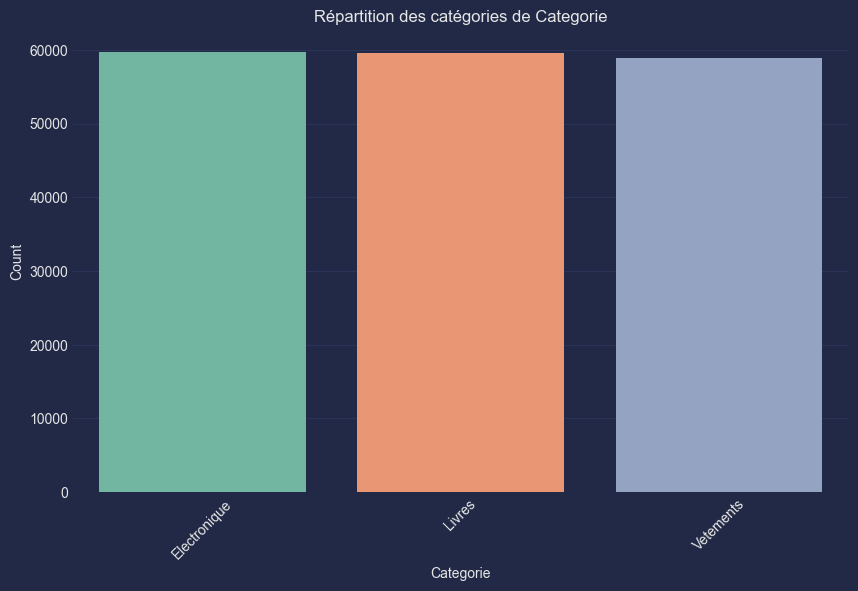



Analyse univariée pour la variable 'SKU':
La variable 'SKU' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Date':
La variable 'Date' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Prix':
╒══════╤═════════╤═════════╤═════════╤═════════╤════════╤═════════╤═════════╤═════════╤═════════╤════════════╕
│      │   count │    mean │     std │     min │    25% │     50% │     75% │     max │    skew │   kurtosis │
╞══════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════╪═════════╪═════════╪═════════╪════════════╡
│ Prix │  178242 │ 220.407 │ 258.544 │ 4.34252 │ 33.988 │ 90.0637 │ 345.878 │ 1180.99 │ 1.33622 │   0.696354 │
╘══════╧═════════╧═════════╧═════════╧═════════╧════════╧═════════╧═════════╧═════════╧═════════╧════════════╛


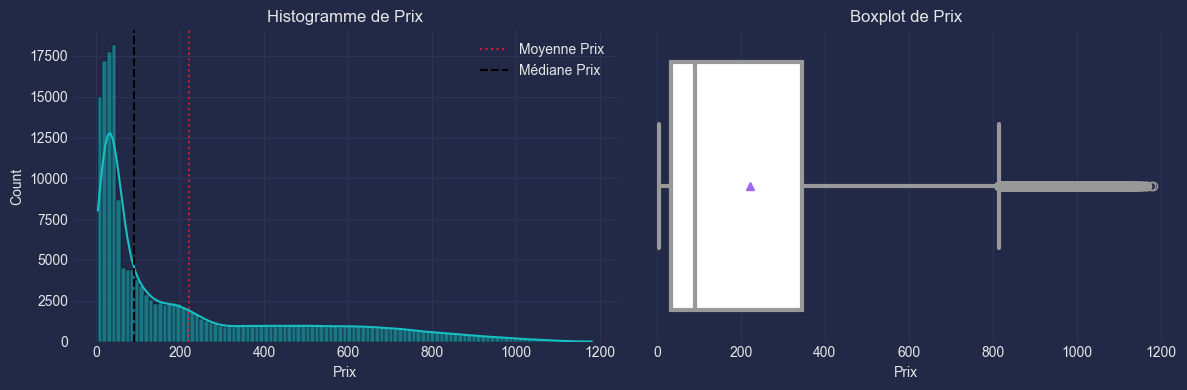



Analyse univariée pour la variable 'PrixInitial':
╒═════════════╤═════════╤════════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╤════════╤════════════╕
│             │   count │   mean │    std │    min │     25% │     50% │     75% │     max │   skew │   kurtosis │
╞═════════════╪═════════╪════════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╪════════╪════════════╡
│ PrixInitial │  178242 │ 245.97 │ 287.74 │ 5.0048 │ 35.2478 │ 107.338 │ 404.108 │ 999.961 │  1.216 │   0.108958 │
╘═════════════╧═════════╧════════╧════════╧════════╧═════════╧═════════╧═════════╧═════════╧════════╧════════════╛


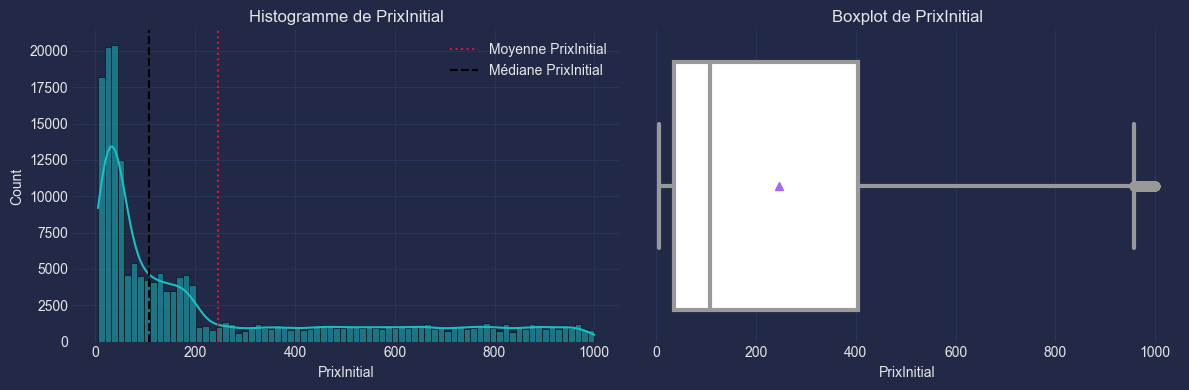



Analyse univariée pour la variable 'DateLancement':
La variable 'DateLancement' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'TempsDepuisLancement':
╒══════════════════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤══════════╤════════════╕
│                      │   count │    mean │     std │   min │   25% │   50% │   75% │   max │     skew │   kurtosis │
╞══════════════════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪══════════╪════════════╡
│ TempsDepuisLancement │  178242 │ 401.424 │ 249.271 │     0 │   190 │   381 │   600 │   872 │ 0.152509 │   -1.07506 │
╘══════════════════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╧══════════╧════════════╛


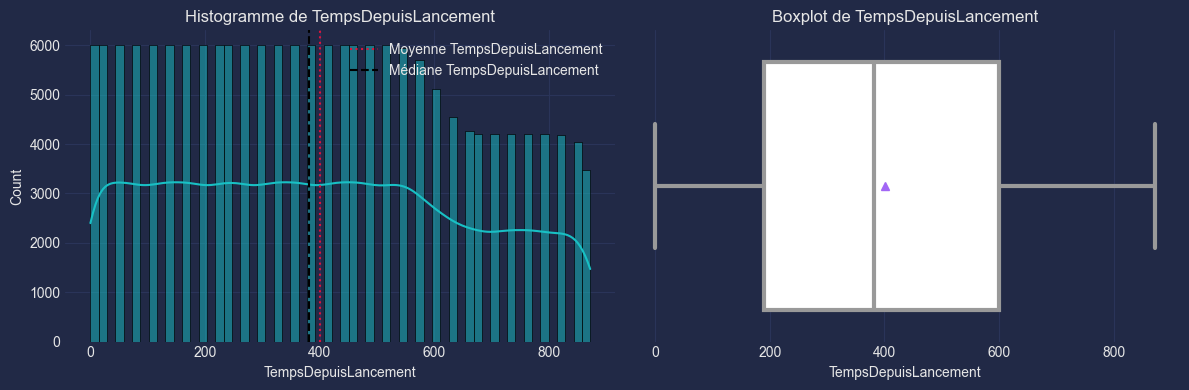



Analyse univariée pour la variable 'CategorieAgeProduit':
╒═════════════════════╤═════════╤══════════╤════════╤════════╕
│                     │   count │   unique │ top    │   freq │
╞═════════════════════╪═════════╪══════════╪════════╪════════╡
│ CategorieAgeProduit │  178242 │        3 │ Ancien │ 108257 │
╘═════════════════════╧═════════╧══════════╧════════╧════════╛
╒════╤═══════════════════════╤═════════╤══════════════╕
│    │ CategorieAgeProduit   │   Count │   Percentage │
╞════╪═══════════════════════╪═════════╪══════════════╡
│  0 │ Ancien                │  108257 │       60.736 │
├────┼───────────────────────┼─────────┼──────────────┤
│  1 │ Moyen                 │   39985 │       22.433 │
├────┼───────────────────────┼─────────┼──────────────┤
│  2 │ Nouveau               │   30000 │       16.831 │
╘════╧═══════════════════════╧═════════╧══════════════╛


c:\Users\samir\Desktop\New Folder With Items\dpm-synthetiques\functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


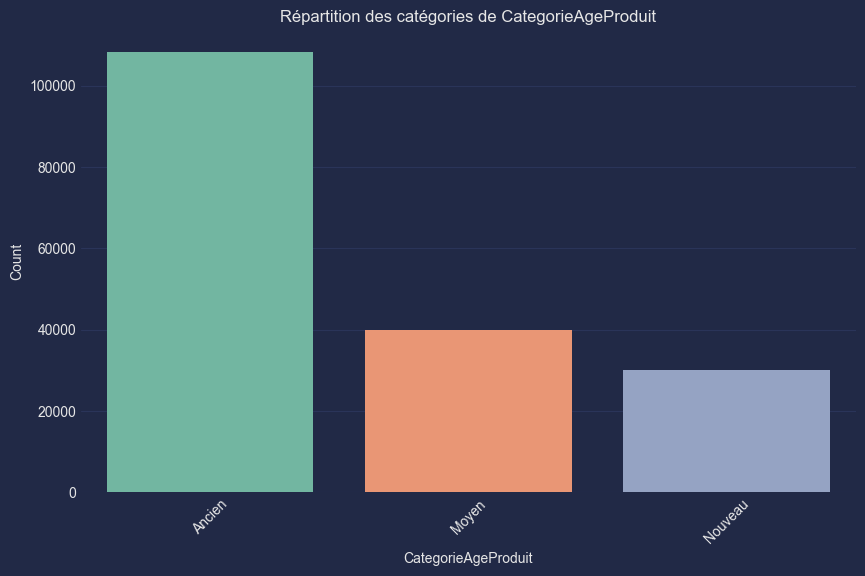



Analyse univariée pour la variable 'NombreDeJoursEnRayon':
╒══════════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤════════╤═════════╤═════════╤════════════╕
│                      │   count │    mean │     std │      min │     25% │     50% │    75% │     max │    skew │   kurtosis │
╞══════════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════╪════════╪═════════╪═════════╪════════════╡
│ NombreDeJoursEnRayon │  178242 │ 210.302 │ 213.604 │ -9.27661 │ 62.9469 │ 171.367 │ 273.03 │ 3561.15 │ 3.03779 │    16.2589 │
╘══════════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧═════════╧════════╧═════════╧═════════╧════════════╛


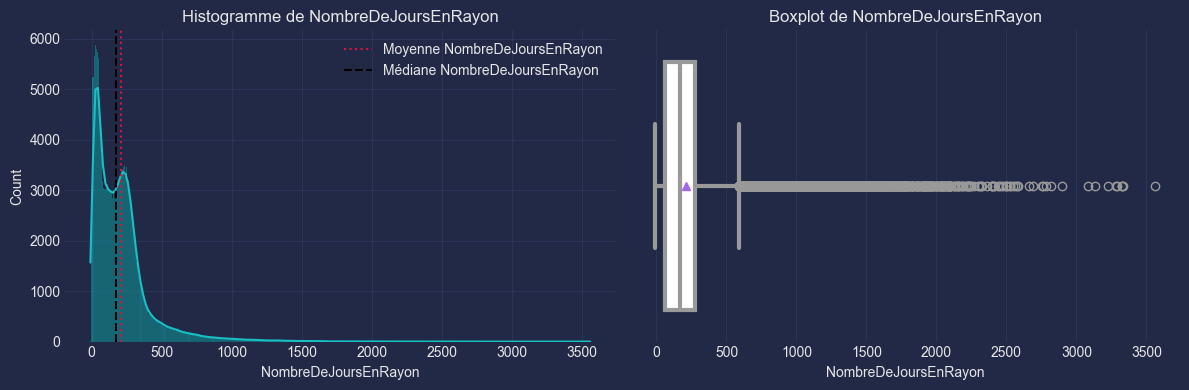



Analyse univariée pour la variable 'Saison':
╒════════╤═════════╤══════════╤═══════╤════════╕
│        │   count │   unique │   top │   freq │
╞════════╪═════════╪══════════╪═══════╪════════╡
│ Saison │  178242 │        4 │     2 │  53045 │
╘════════╧═════════╧══════════╧═══════╧════════╛
╒════╤══════════╤═════════╤══════════════╕
│    │   Saison │   Count │   Percentage │
╞════╪══════════╪═════════╪══════════════╡
│  0 │        2 │   53045 │      29.7601 │
├────┼──────────┼─────────┼──────────────┤
│  1 │        1 │   50237 │      28.1847 │
├────┼──────────┼─────────┼──────────────┤
│  2 │        4 │   38150 │      21.4035 │
├────┼──────────┼─────────┼──────────────┤
│  3 │        3 │   36810 │      20.6517 │
╘════╧══════════╧═════════╧══════════════╛


c:\Users\samir\Desktop\New Folder With Items\dpm-synthetiques\functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


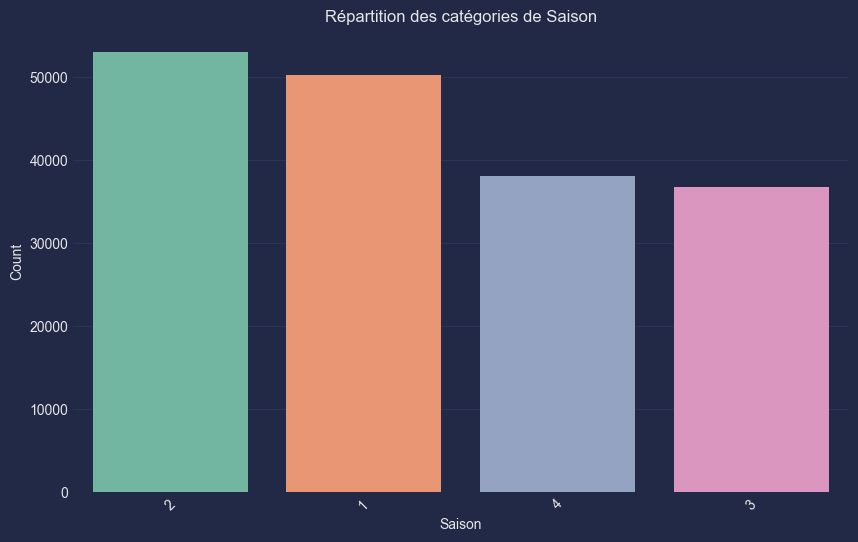



Analyse univariée pour la variable 'TauxInflation':
╒═══════════════╤═════════╤═══════════╤═══════════╤═══════╤════════╤═══════╤═══════╤═══════╤═════════╤════════════╕
│               │   count │      mean │       std │   min │    25% │   50% │   75% │   max │    skew │   kurtosis │
╞═══════════════╪═════════╪═══════════╪═══════════╪═══════╪════════╪═══════╪═══════╪═══════╪═════════╪════════════╡
│ TauxInflation │  178242 │ 0.0156368 │ 0.0148529 │     0 │ 0.0036 │ 0.013 │ 0.017 │ 0.058 │ 1.29907 │   0.778024 │
╘═══════════════╧═════════╧═══════════╧═══════════╧═══════╧════════╧═══════╧═══════╧═══════╧═════════╧════════════╛


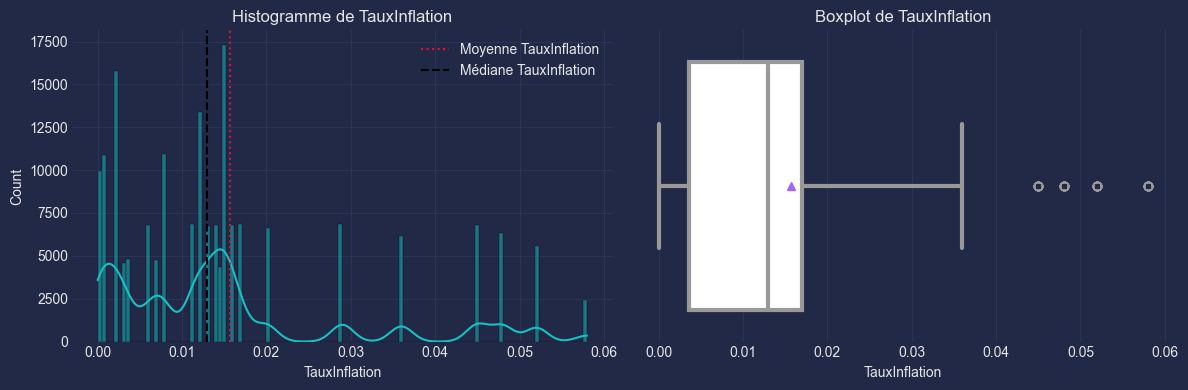



Analyse univariée pour la variable 'Elasticite':
╒════════════╤═════════╤═════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════════╤════════════╕
│            │   count │    mean │      std │   min │   25% │   50% │   75% │   max │        skew │   kurtosis │
╞════════════╪═════════╪═════════╪══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════════╪════════════╡
│ Elasticite │  178242 │ 1.00226 │ 0.407877 │   0.5 │   0.5 │     1 │   1.5 │   1.5 │ -0.00831027 │   -1.49722 │
╘════════════╧═════════╧═════════╧══════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═════════════╧════════════╛


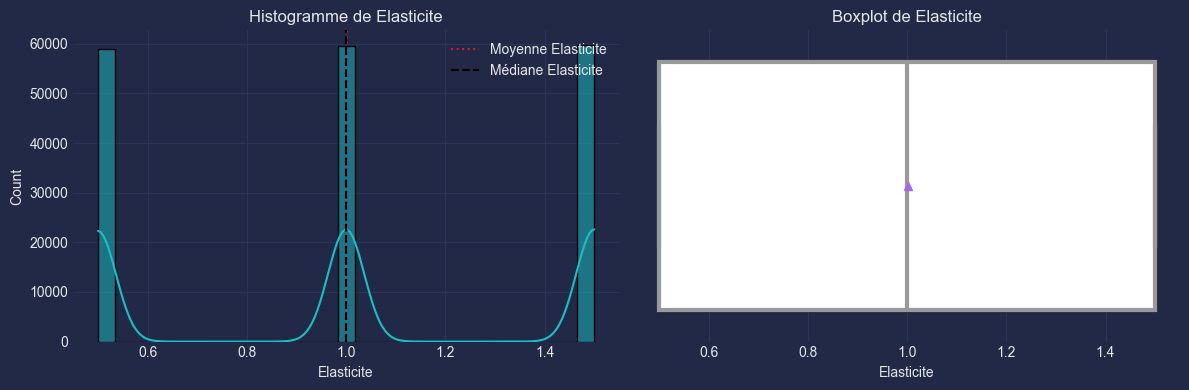



Analyse univariée pour la variable 'ChocDemande':
╒═════════════╤═════════╤═════════════╤═══════════╤════════════╤════════════╤══════════════╤═══════════╤═══════════╤════════════╤════════════╕
│             │   count │        mean │       std │        min │        25% │          50% │       75% │       max │       skew │   kurtosis │
╞═════════════╪═════════╪═════════════╪═══════════╪════════════╪════════════╪══════════════╪═══════════╪═══════════╪════════════╪════════════╡
│ ChocDemande │  178242 │ 3.37358e-05 │ 0.0576814 │ -0.0999925 │ -0.0497653 │ -0.000167413 │ 0.0501592 │ 0.0999999 │ 0.00133784 │   -1.19909 │
╘═════════════╧═════════╧═════════════╧═══════════╧════════════╧════════════╧══════════════╧═══════════╧═══════════╧════════════╧════════════╛


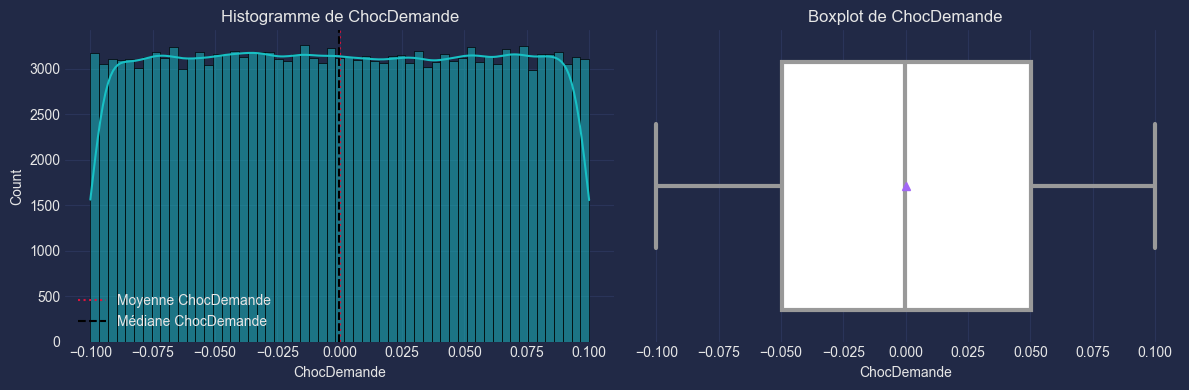



Analyse univariée pour la variable 'ChangementPrix':
╒════════════════╤═════════╤══════════╤═════════╤══════════╤══════════╤═══════════╤═════════╤═════════╤══════════╤════════════╕
│                │   count │     mean │     std │      min │      25% │       50% │     75% │     max │     skew │   kurtosis │
╞════════════════╪═════════╪══════════╪═════════╪══════════╪══════════╪═══════════╪═════════╪═════════╪══════════╪════════════╡
│ ChangementPrix │  178242 │ -25.5625 │ 67.3352 │ -465.692 │ -44.1247 │ -0.712152 │ 3.84726 │ 188.783 │ -1.77473 │    4.18751 │
╘════════════════╧═════════╧══════════╧═════════╧══════════╧══════════╧═══════════╧═════════╧═════════╧══════════╧════════════╛


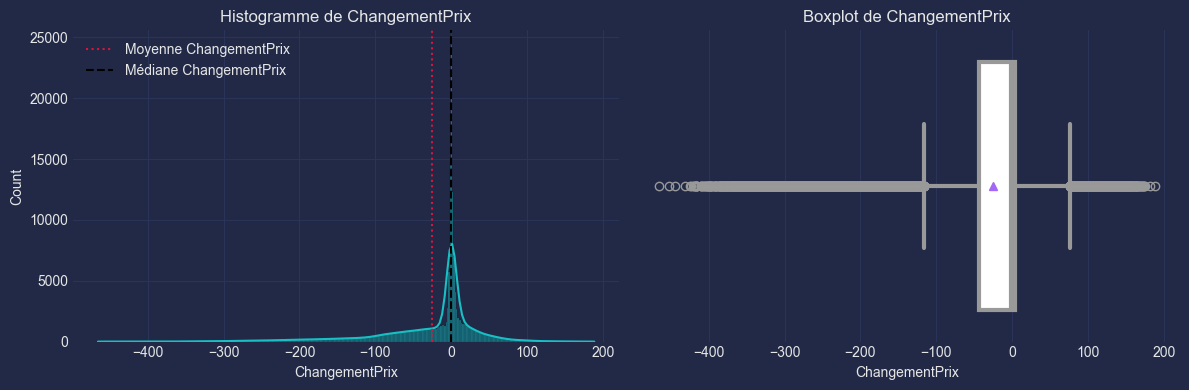



Analyse univariée pour la variable 'FacteurRarete':
╒═══════════════╤═════════╤══════════╤═══════════╤══════════╤══════════╤══════════╤═════════╤═══════╤════════════╤════════════╕
│               │   count │     mean │       std │      min │      25% │      50% │     75% │   max │       skew │   kurtosis │
╞═══════════════╪═════════╪══════════╪═══════════╪══════════╪══════════╪══════════╪═════════╪═══════╪════════════╪════════════╡
│ FacteurRarete │  178242 │ 0.999798 │ 0.0577615 │ 0.900001 │ 0.949636 │ 0.999708 │ 1.04984 │   1.1 │ 0.00319248 │   -1.20298 │
╘═══════════════╧═════════╧══════════╧═══════════╧══════════╧══════════╧══════════╧═════════╧═══════╧════════════╧════════════╛


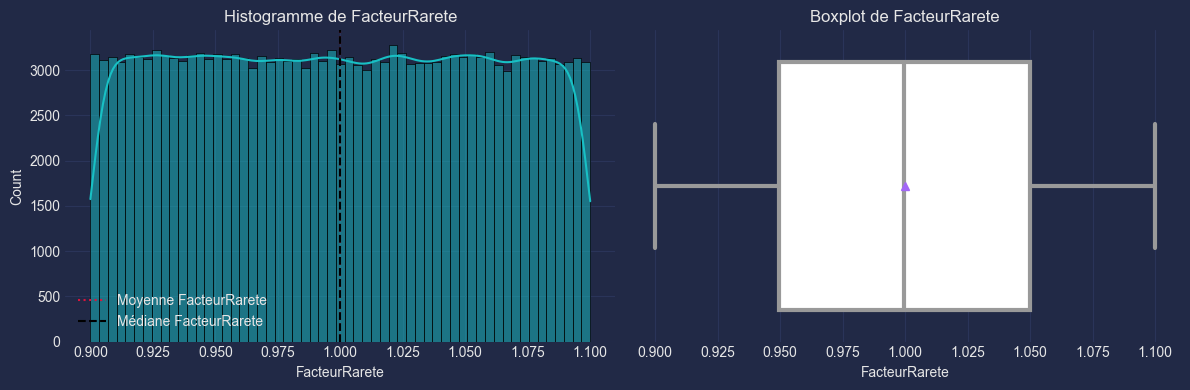



Analyse univariée pour la variable 'FacteurSaison':
╒═══════════════╤═════════╤═════════╤═══════════╤═══════╤═══════╤═══════╤════════╤═══════╤═══════════╤════════════╕
│               │   count │    mean │       std │   min │   25% │   50% │    75% │   max │      skew │   kurtosis │
╞═══════════════╪═════════╪═════════╪═══════════╪═══════╪═══════╪═══════╪════════╪═══════╪═══════════╪════════════╡
│ FacteurSaison │  178242 │ 1.00702 │ 0.0694407 │   0.9 │  0.95 │     1 │ 1.0866 │   1.1 │ -0.152672 │   -1.43806 │
╘═══════════════╧═════════╧═════════╧═══════════╧═══════╧═══════╧═══════╧════════╧═══════╧═══════════╧════════════╛


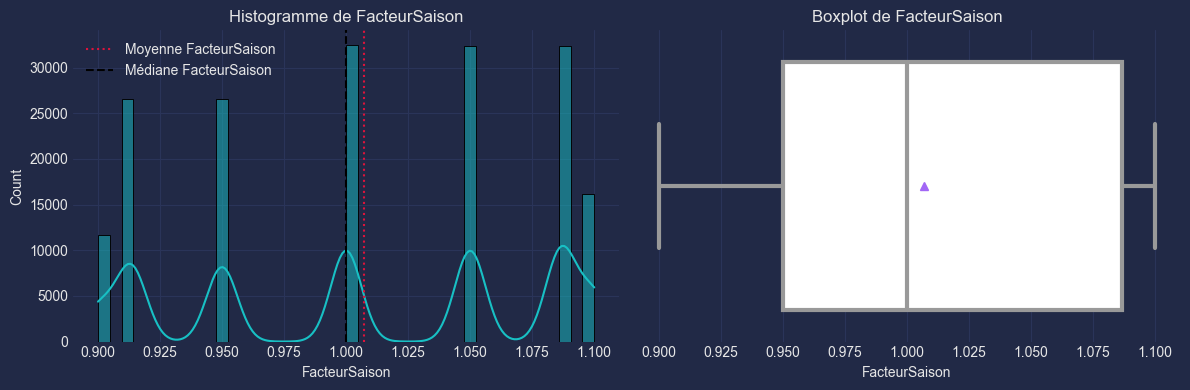



Analyse univariée pour la variable 'MarcheAleatoire':
╒═════════════════╤═════════╤═════════╤═════════╤═════════╤════════╤═════════╤═════════╤═════════╤═════════╤════════════╕
│                 │   count │    mean │     std │     min │    25% │     50% │     75% │     max │    skew │   kurtosis │
╞═════════════════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════╪═════════╪═════════╪═════════╪════════════╡
│ MarcheAleatoire │  178242 │ 220.407 │ 258.544 │ 4.34252 │ 33.988 │ 90.0637 │ 345.878 │ 1180.99 │ 1.33622 │   0.696354 │
╘═════════════════╧═════════╧═════════╧═════════╧═════════╧════════╧═════════╧═════════╧═════════╧═════════╧════════════╛


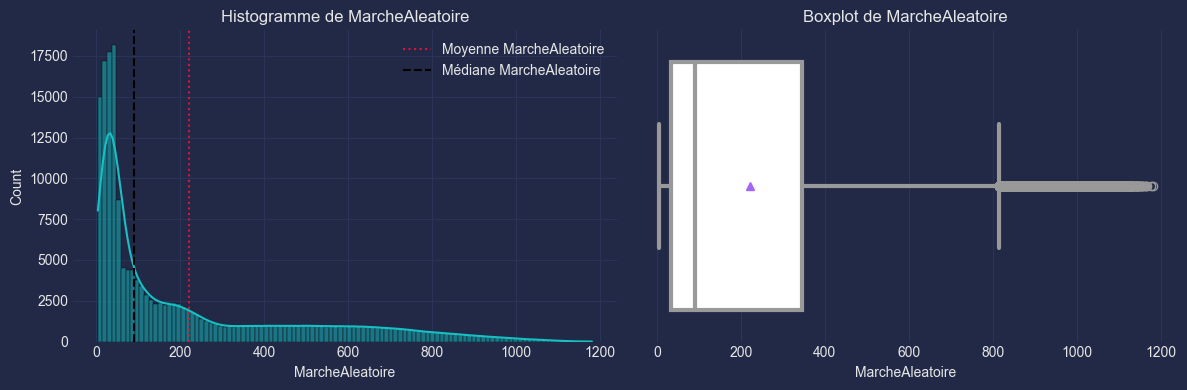



Analyse univariée pour la variable 'ChocDemandeCumulatif':
╒══════════════════════╤═════════╤════════════╤══════════╤══════════╤═══════════╤══════════════╤══════════╤═════════╤═════════════╤════════════╕
│                      │   count │       mean │      std │      min │       25% │          50% │      75% │     max │        skew │   kurtosis │
╞══════════════════════╪═════════╪════════════╪══════════╪══════════╪═══════════╪══════════════╪══════════╪═════════╪═════════════╪════════════╡
│ ChocDemandeCumulatif │  178242 │ 0.00033514 │ 0.228882 │ -1.18875 │ -0.132491 │ -4.33676e-05 │ 0.133974 │ 1.36231 │ -0.00307193 │   0.961053 │
╘══════════════════════╧═════════╧════════════╧══════════╧══════════╧═══════════╧══════════════╧══════════╧═════════╧═════════════╧════════════╛


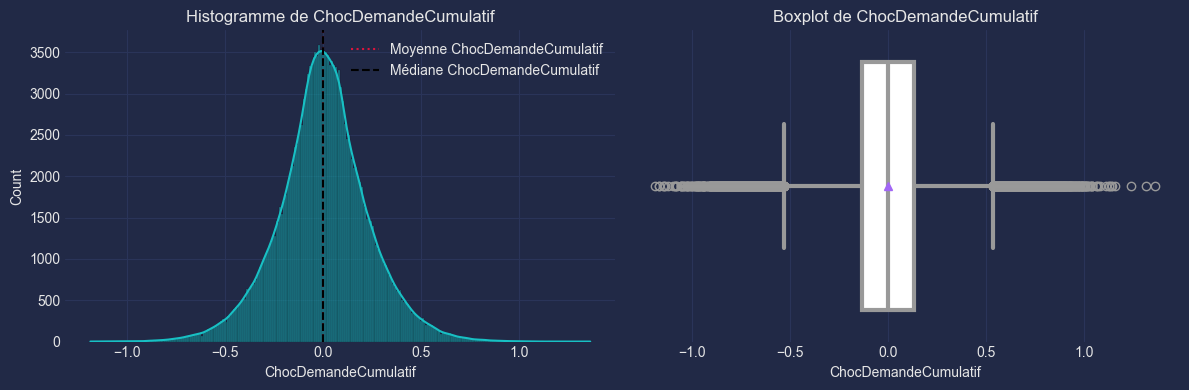



Analyse univariée pour la variable 'AgeProduitEnJours':
╒═══════════════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤══════════╤════════════╕
│                   │   count │    mean │     std │   min │   25% │   50% │   75% │   max │     skew │   kurtosis │
╞═══════════════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪══════════╪════════════╡
│ AgeProduitEnJours │  178242 │ 401.424 │ 249.271 │     0 │   190 │   381 │   600 │   872 │ 0.152509 │   -1.07506 │
╘═══════════════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╧══════════╧════════════╛


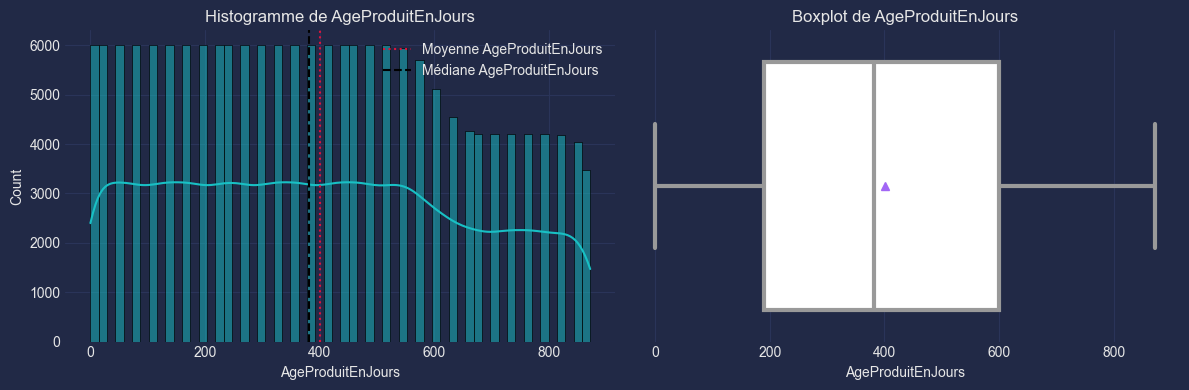



Analyse univariée pour la variable 'elasticite_cat':
╒════════════════╤═════════╤══════════╤═══════════╤════════╕
│                │   count │   unique │ top       │   freq │
╞════════════════╪═════════╪══════════╪═══════════╪════════╡
│ elasticite_cat │  178242 │        3 │ Elastique │  59711 │
╘════════════════╧═════════╧══════════╧═══════════╧════════╛
╒════╤══════════════════╤═════════╤══════════════╕
│    │ elasticite_cat   │   Count │   Percentage │
╞════╪══════════════════╪═════════╪══════════════╡
│  0 │ Elastique        │   59711 │      33.5    │
├────┼──────────────────┼─────────┼──────────────┤
│  1 │ Neutre           │   59627 │      33.4528 │
├────┼──────────────────┼─────────┼──────────────┤
│  2 │ Inelastique      │   58904 │      33.0472 │
╘════╧══════════════════╧═════════╧══════════════╛


c:\Users\samir\Desktop\New Folder With Items\dpm-synthetiques\functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


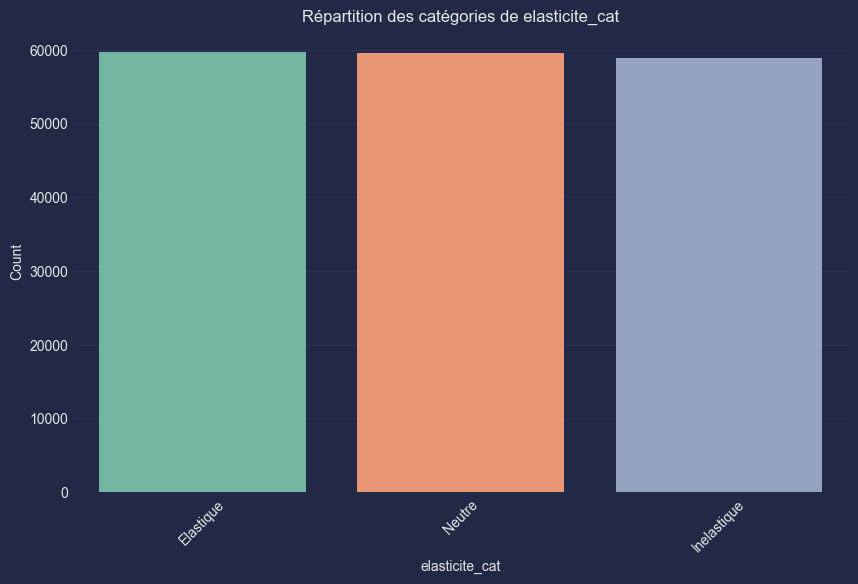

In [12]:
analyse_univariee(df_synth)

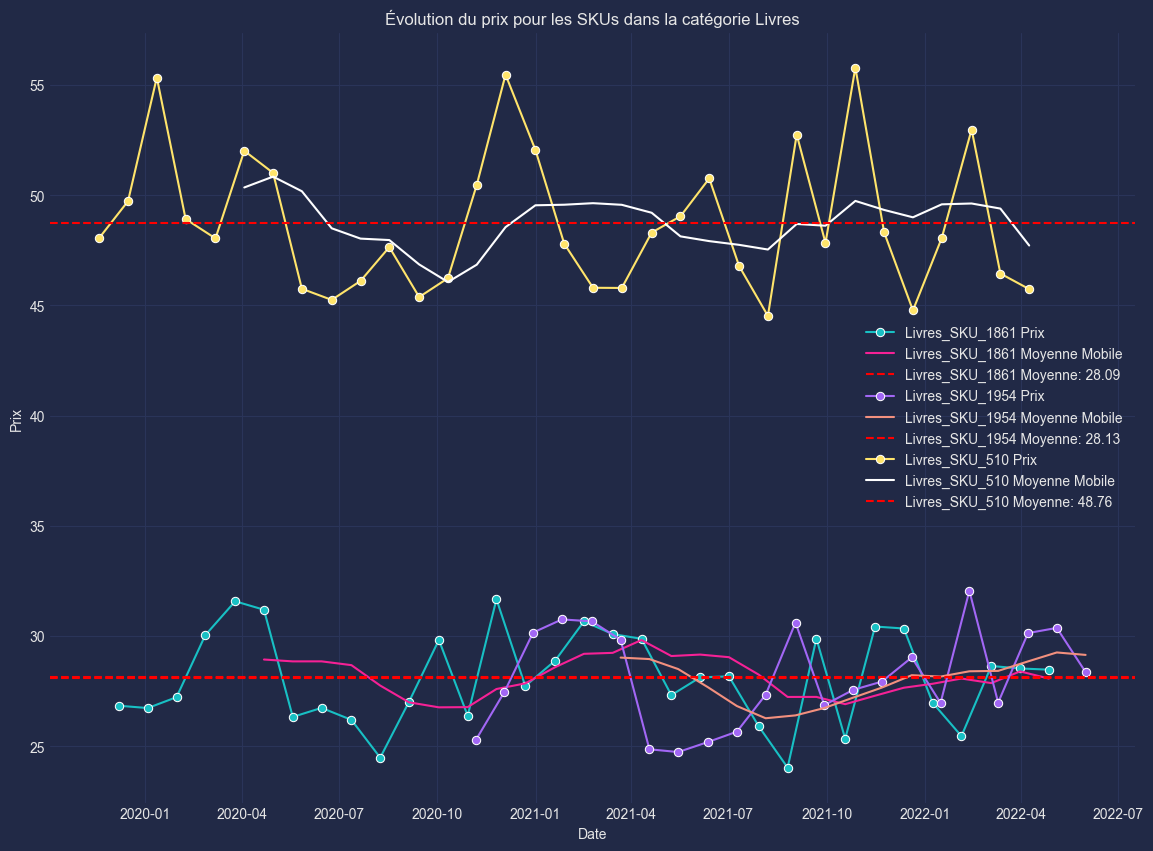

In [13]:
tracer_skus_pour_categorie(df_synth, categorie="Livres", nombre_skus=3, moyenne_mobile_mois=6)

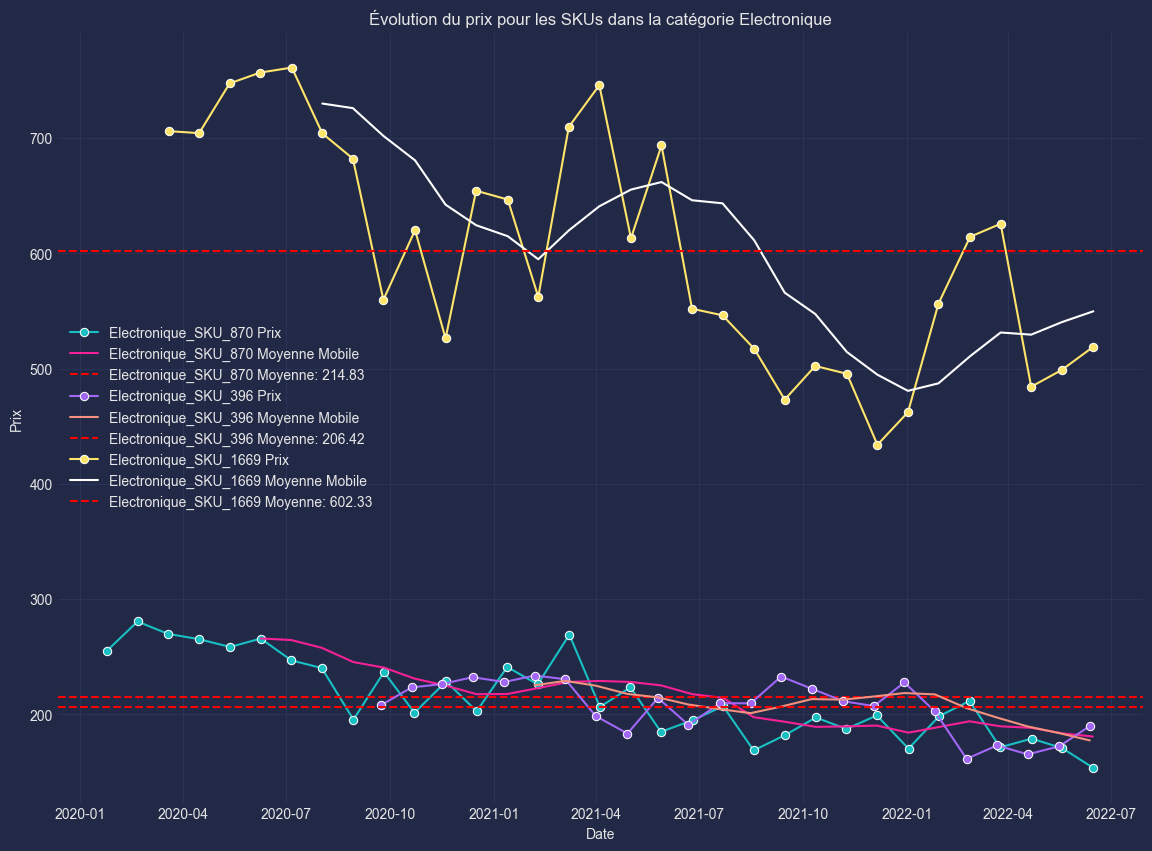

In [14]:
tracer_skus_pour_categorie(df_synth, categorie="Electronique", nombre_skus=3, moyenne_mobile_mois=6)


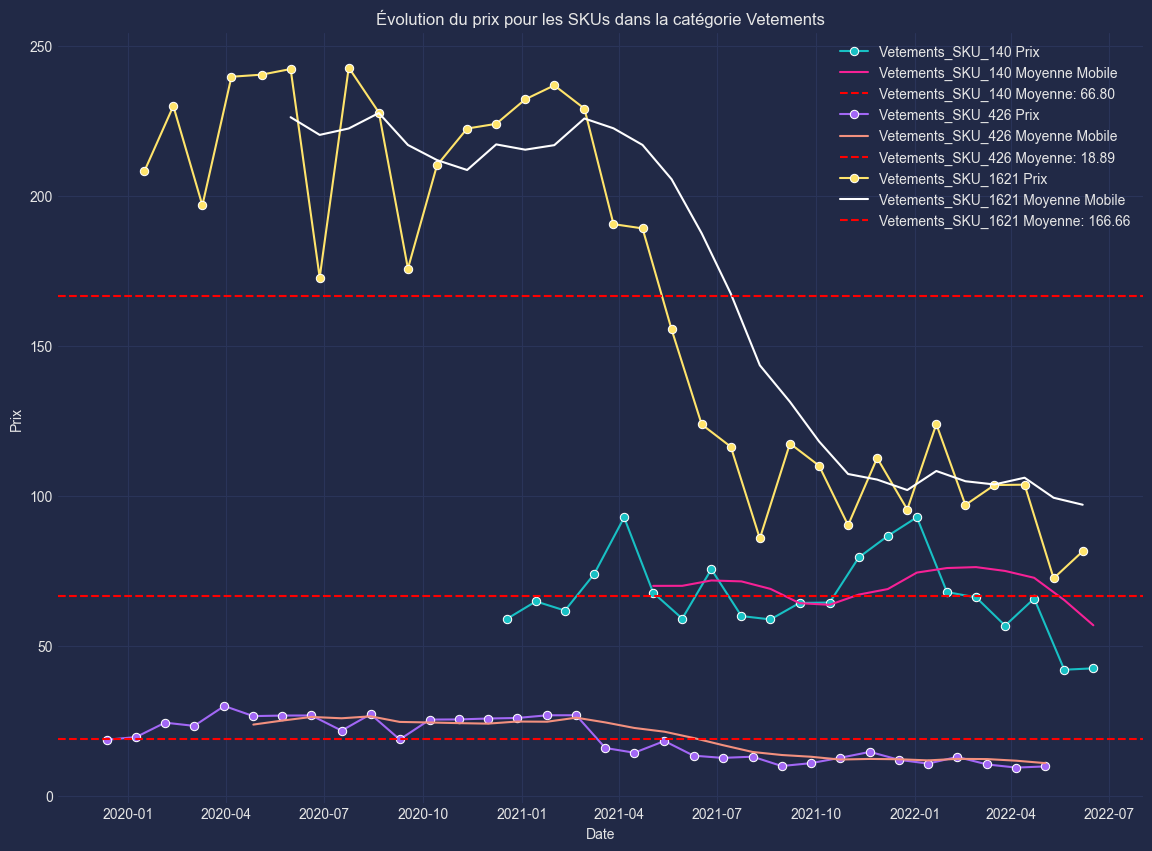

In [15]:
tracer_skus_pour_categorie(df_synth, categorie="Vetements", nombre_skus=3, moyenne_mobile_mois=6)


## 1.2 **Feature Engineering & Préprocessing**

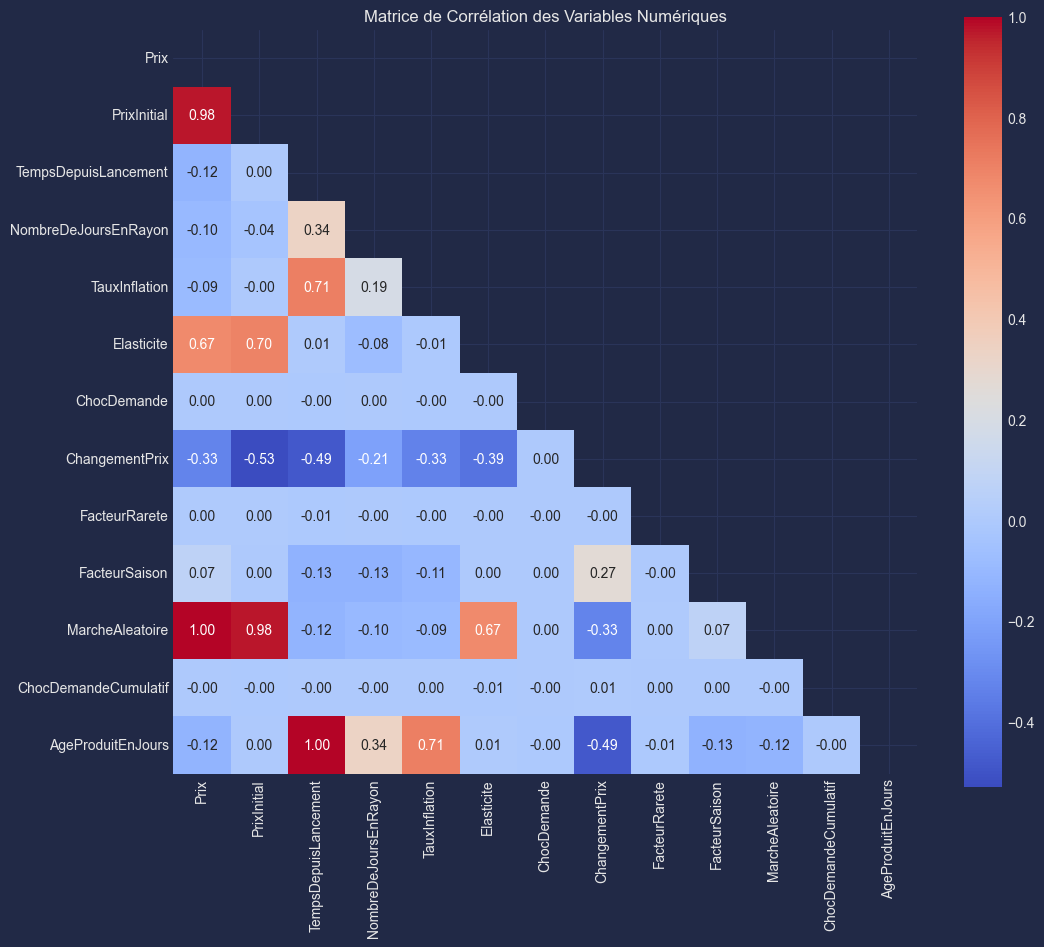

In [16]:
numeric_columns = [
    'Prix', 'PrixInitial', 'TempsDepuisLancement', 'NombreDeJoursEnRayon', 'TauxInflation',
    'Elasticite', 'ChocDemande', 'ChangementPrix', 'FacteurRarete', 'FacteurSaison',
    'MarcheAleatoire', 'ChocDemandeCumulatif', 'AgeProduitEnJours'
]

# Calculer la matrice de corrélation
corr = df_synth[numeric_columns].corr()

# Créer un masque pour la partie supérieure de la matrice
mask = np.triu(np.ones_like(corr, dtype=bool))

# Créer une heatmap avec seaborn
plt.figure(figsize=(12, 10))  # Définir la taille de la figure
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar=True, square=True)

# Afficher la heatmap
plt.title('Matrice de Corrélation des Variables Numériques')
plt.show()

In [17]:
# Sélection des colonnes catégorielles pour One-Hot Encoding
cat_columns = df.select_dtypes(include=['category']).columns

# Application du One-Hot Encoding sur les colonnes catégorielles pour tous les jeux de données
df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True)
df_validation_encoded = pd.get_dummies(df_validation, columns=cat_columns, drop_first=True)
df_light_encoded = pd.get_dummies(df_light, columns=cat_columns, drop_first=True)
df_light_validation_encoded = pd.get_dummies(df_light_validation, columns=cat_columns, drop_first=True)


In [18]:
# Identification des colonnes à transformer
colonnes_a_transformer = ["Prix", "NombreDeJoursEnRayon", "PrixInitial"]

# Transformation logarithmique appliquée aux colonnes spécifiées pour tous les jeux de données
for col in colonnes_a_transformer:
    for df_temp in [df_encoded, df_validation_encoded, df_light_encoded, df_light_validation_encoded]:
        df_temp[col] = df_temp[col].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Remplissage des valeurs NaN résultant des log(0) ou valeurs négatives (optionnel, selon le contexte)
for df_temp in [df_encoded, df_validation_encoded, df_light_encoded, df_light_validation_encoded]:
    df_temp.fillna(0, inplace=True)


In [19]:
# Extraction des composantes temporelles des colonnes 'Date' et 'DateLancement' pour tous les jeux de données
for df_temp in [df_encoded, df_validation_encoded, df_light_encoded, df_light_validation_encoded]:
    df_temp['year'] = df_temp['Date'].dt.year
    df_temp['month'] = df_temp['Date'].dt.month
    df_temp['day'] = df_temp['Date'].dt.day
    df_temp['dayofweek'] = df_temp['Date'].dt.dayofweek
    df_temp['is_weekend'] = df_temp['Date'].dt.dayofweek >= 5

    df_temp['launch_year'] = df_temp['DateLancement'].dt.year
    df_temp['launch_month'] = df_temp['DateLancement'].dt.month
    df_temp['launch_day'] = df_temp['DateLancement'].dt.day
    df_temp['launch_dayofweek'] = df_temp['DateLancement'].dt.dayofweek
    df_temp['launch_is_weekend'] = df_temp['DateLancement'].dt.dayofweek >= 5

In [20]:
# Identification des colonnes numériques à standardiser (excluant celles issues du One-Hot Encoding)
num_col = [
    'PrixInitial', 'TempsDepuisLancement', 'NombreDeJoursEnRayon', 'TauxInflation',
    'Elasticite', 'ChocDemande', 'FacteurRarete', 'FacteurSaison', 'AgeProduitEnJours',
    'year', 'month', 'day', 'dayofweek', 'launch_year', 'launch_month', 'launch_day', 'launch_dayofweek'
]

# Application de la standardisation sur les colonnes numériques pour tous les jeux de données
scaler = StandardScaler()
df_encoded[num_col] = scaler.fit_transform(df_encoded[num_col])
df_validation_encoded[num_col] = scaler.transform(df_validation_encoded[num_col])
df_light_encoded[num_col] = scaler.transform(df_light_encoded[num_col])
df_light_validation_encoded[num_col] = scaler.transform(df_light_validation_encoded[num_col])

In [24]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161115 entries, 0 to 178240
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   SKU                          161115 non-null  object        
 1   Date                         161115 non-null  datetime64[ns]
 2   Prix                         161115 non-null  float64       
 3   PrixInitial                  161115 non-null  float64       
 4   DateLancement                161115 non-null  datetime64[ns]
 5   TempsDepuisLancement         161115 non-null  float64       
 6   NombreDeJoursEnRayon         161115 non-null  float64       
 7   TauxInflation                161115 non-null  float64       
 8   Elasticite                   161115 non-null  float64       
 9   ChocDemande                  161115 non-null  float64       
 10  ChangementPrix               161115 non-null  float64       
 11  FacteurRarete             

----------------------------------

In [22]:
# Chemin vers le répertoire où vous voulez enregistrer les fichiers
directory = "data_prepro/"

# Vérification si le répertoire existe, sinon le créer
if not os.path.exists(directory):
    os.makedirs(directory)

# Sauvegarder les fichiers dans le répertoire nouvellement créé

df_encoded.to_csv(directory + "donnees_entrainement", index=False)
df_validation_encoded.to_csv(directory + "donnees_validation", index=False)

df_light_encoded.to_csv(directory + "donnees_entrainement_light", index=False)
df_light_validation_encoded.to_csv(directory + "donnees_validation_light", index=False)